In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


## Loading and cleaing the dataset

In [2]:
# Load the original .txt file
df = pd.read_csv("../data/MachineLearningRating_v3.txt", delimiter="|")

# Check basic info
df.info()

# Drop rows where TotalPremium or TotalClaims is missing or zero (to avoid divide by zero)
df = df.dropna(subset=["TotalPremium", "TotalClaims", "Province", "PostalCode", "Gender"])
df = df[(df["TotalPremium"] > 0)]

# Calculate Loss Ratio
df["LossRatio"] = df["TotalClaims"] / df["TotalPremium"]

# Optional: Remove extreme outliers (if needed)
df = df[df["LossRatio"] < 10]

# Save cleaned version
df.to_csv("../data/cleaned_insurance_data.csv", index=False)

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,LossRatio
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,0.0
5,145247,12827,2015-01-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,3.256435,0.0,0.0
6,145247,12827,2015-04-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,50.474737,0.0,0.0


In [3]:
# Group by Province and collect Loss Ratios
province_groups = [group["LossRatio"].values for name, group in df.groupby("Province")]

# Run ANOVA
f_stat, p_val = stats.f_oneway(*province_groups)

print("ANOVA Test: Loss Ratio by Province")
print("F-statistic:", f_stat)
print("p-value:", p_val)
if p_val < 0.05:
    print("👉 Reject null hypothesis: Risk differs significantly between provinces.")
else:
    print("👉 Fail to reject null hypothesis: No significant risk difference between provinces.")


ANOVA Test: Loss Ratio by Province
F-statistic: 0.8024391638015184
p-value: 0.6003486541158997
👉 Fail to reject null hypothesis: No significant risk difference between provinces.


In [4]:
# Split by gender
male_loss = df[df["Gender"] == "Male"]["LossRatio"]
female_loss = df[df["Gender"] == "Female"]["LossRatio"]

# Run T-test
t_stat, p_val = stats.ttest_ind(male_loss, female_loss, equal_var=False)

print("T-Test: Loss Ratio between Genders")
print("T-statistic:", t_stat)
print("p-value:", p_val)
if p_val < 0.05:
    print("👉 Reject null hypothesis: Risk differs significantly between men and women.")
else:
    print("👉 Fail to reject null hypothesis: No significant difference.")


T-Test: Loss Ratio between Genders
T-statistic: 1.7679956151962286
p-value: 0.07707527768241193
👉 Fail to reject null hypothesis: No significant difference.


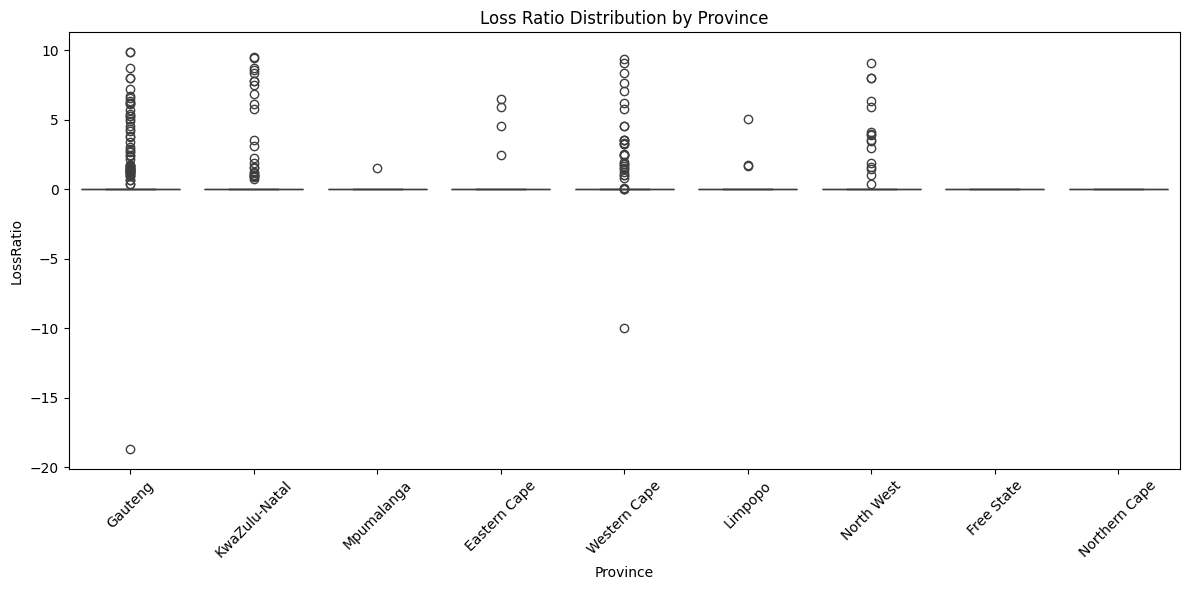

In [5]:
# Boxplot of LossRatio by Province
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Province", y="LossRatio")
plt.title("Loss Ratio Distribution by Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Hypothesis


In [ ]:
# Step 1: Calculate Profit Margin and Prepare Data

# Calculate Profit Margin
df["ProfitMargin"] = (df["TotalPremium"] - df["TotalClaims"]) / df["TotalPremium"]

# Drop rows with missing PostalCode or ProfitMargin
df_zip = df.dropna(subset=["PostalCode", "ProfitMargin"])

# Optional: filter extreme profit margins (e.g., losses greater than 100%)
df_zip = df_zip[(df_zip["ProfitMargin"] > -5) & (df_zip["ProfitMargin"] < 5)]

df_zip[["PostalCode", "LossRatio", "ProfitMargin"]].head()


,PostalCode,LossRatio,ProfitMargin
0,1459,0.0,1.0
1,1459,0.0,1.0
3,1459,0.0,1.0
5,1459,0.0,1.0
6,1459,0.0,1.0


In [9]:
# Step 2: Test for Loss Ratio Differences by Zipcode (Kruskal-Wallis)
from scipy.stats import kruskal

# Filter for top 10 most frequent zipcodes to keep test manageable
top_zipcodes = df_zip["PostalCode"].value_counts().nlargest(10).index
filtered = df_zip[df_zip["PostalCode"].isin(top_zipcodes)]

# Prepare LossRatio groups
groups = [group["LossRatio"].values for _, group in filtered.groupby("PostalCode")]

# Kruskal-Wallis test (non-parametric alternative to ANOVA)
h_stat, p_val = kruskal(*groups)

print("Kruskal-Wallis Test: Loss Ratio by Zipcode")
print("H-statistic:", h_stat)
print("p-value:", p_val)
if p_val < 0.05:
    print("👉 Reject null hypothesis: Risk differs significantly between Zipcodes.")
else:
    print("👉 Fail to reject null hypothesis: No significant difference.")


Kruskal-Wallis Test: Loss Ratio by Zipcode
H-statistic: 49.627319145526506
p-value: 1.265750279842692e-07
👉 Reject null hypothesis: Risk differs significantly between Zipcodes.


In [10]:
# Step 3: Test for Profit Margin Differences by Zipcode (Kruskal-Wallis)

# Prepare ProfitMargin groups
profit_groups = [group["ProfitMargin"].values for _, group in filtered.groupby("PostalCode")]

# Kruskal-Wallis test
h_stat, p_val = kruskal(*profit_groups)

print("Kruskal-Wallis Test: Profit Margin by Zipcode")
print("H-statistic:", h_stat)
print("p-value:", p_val)
if p_val < 0.05:
    print("👉 Reject null hypothesis: Profit margins differ significantly across Zipcodes.")
else:
    print("👉 Fail to reject null hypothesis: No significant difference in profit margin.")


Kruskal-Wallis Test: Profit Margin by Zipcode
H-statistic: 49.627319145526506
p-value: 1.265750279842692e-07
👉 Reject null hypothesis: Profit margins differ significantly across Zipcodes.


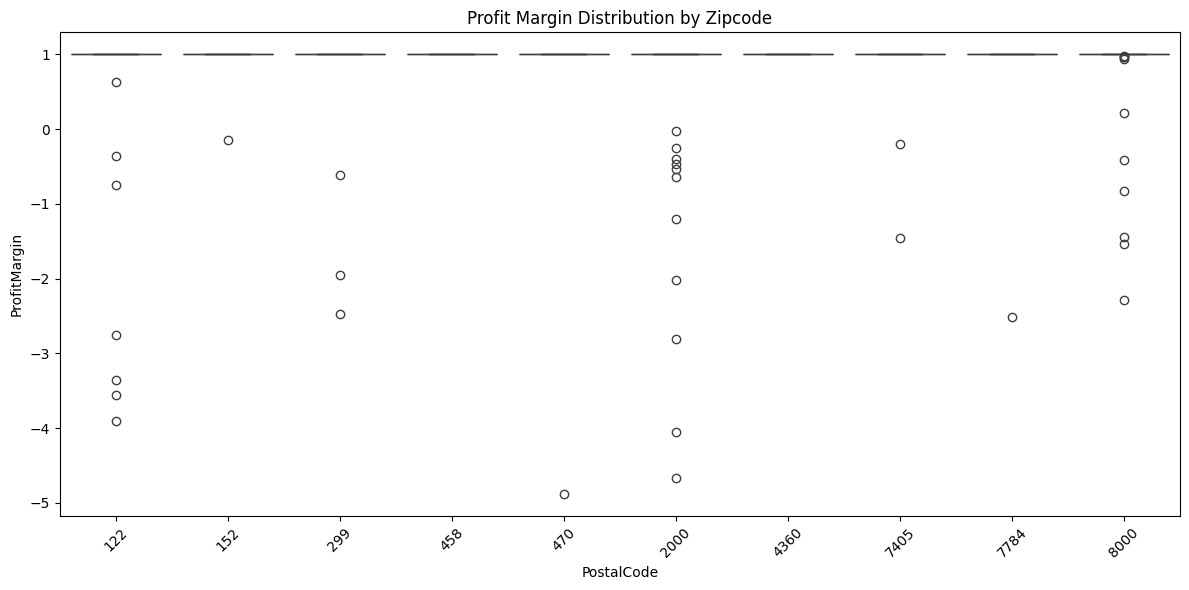

In [12]:
# Step 4: Visualize Profit Margin by Zipcode

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered, x="PostalCode", y="ProfitMargin")
plt.title("Profit Margin Distribution by Zipcode")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()